# User Guide

This is a complete tour of Temporian's capabilities. For a brief introduction to how the library works, please refer to [3 minutes to Temporian](./3_minutes).


## What is temporal data?

In Temporian, there is only one type of data: **multivariate multi-index time sequences** (MMITS). MMITS extends many commonly used data formats such as time-series and transactions to allow multi-variate data, non-uniform sampling, non-aligned sampling, and hierarchically-structured data. In that, MMITSs are particularly well suited to represent classical time-series, but also transactions, logs, sparse events, asynchronous measurements, and hierarchical records.

<!-- TODO: add plot -->

## Events and EventSets

The unit of data in Temporian is referred to as an _event_. An event consists of a timestamp and a set of feature values.

Here is an example of an event:

```
timestamp: 2023-02-05
feature_1: 0.5
feature_2: "red"
feature_3: 10
```

Events are not handled individually. Instead, events are grouped together into [EventSet][temporian.EventSet]s. When representing an `EventSet`, it is convenient to group similar features together and to sort them according to the timestamps in increasing order.

Here is an example of an `EventSet` containing four events and three features:

```
timestamp: [04-02-2023, 06-02-2023, 07-02-2023, 07-02-2023]
feature_1: [0.5, 0.6, NaN, 0.9]
feature_2: ["red", "blue", "red", "blue"]
feature_3:  [10, -1, 5, 5]
```

**Remarks:**

- All values for a given feature are of the same data type. For instance, `feature_1` is float64 while `feature_2` is a string.
- Many operators interpret the value NaN (for _not a number_) as missing.
- Timestamps are not necessarily uniformly sampled.
- The same timestamp can be repeated.
- The events withing an EventSet are sampled synchronously. However, different EventSets might be sampled differently.

In the next code examples, variables with names like `evset` refer to an `EventSet`.

You can create an `EventSet` as follows:

In [1]:
import temporian as tp
import pandas as pd
import numpy as np

evset = tp.event_set(
	timestamps=["2023-02-04","2023-02-06","2023-02-07","2023-02-07"],
	features={
        "feature_1": [0.5, 0.6, np.nan, 0.9],
        "feature_2": ["red", "blue", "red", "blue"],
        "feature_3":  [10, -1, 5, 5],
	}
)


`EventSets` can be printed.

In [2]:
print(evset)

indexes: []
features: [('feature_1', float64), ('feature_2', str_), ('feature_3', int64)]
events:
     (4 events):
        timestamps: [1.6755e+09 1.6756e+09 1.6757e+09 1.6757e+09]
        'feature_1': [0.5 0.6 nan 0.9]
        'feature_2': [b'red' b'blue' b'red' b'blue']
        'feature_3': [10 -1  5  5]
memory usage: 0.8 kB



`EventSets` can be plotted.

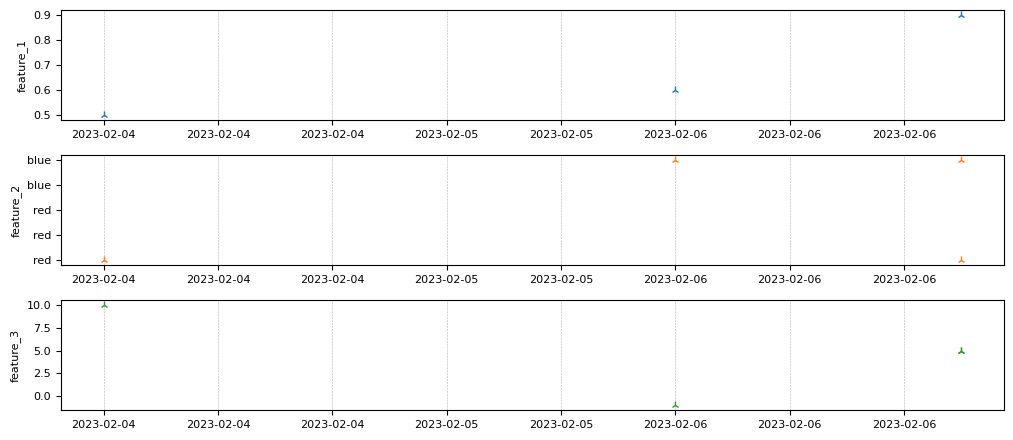

In [3]:
evset.plot()


**Note:** You'll learn how to create an `EventSet` using other data sources such as pandas DataFrames later.

Events can carry various meanings. For instance, events can represent **regular measurements**. Suppose an electronic thermometer that generates temperature measurements every minute. This could be an `EventSet` with one feature called `temperature`. In this scenario, the temperature can change between two measurements. However, for most practical uses, the most recent measurement will be considered the current temperature.

<!-- TODO: Temperature plot -->

Events can also represent the _occurrence_ of sporadic phenomena. Suppose a sales recording system that records client purchases. Each time a client makes a purchase (i.e., each transaction), a new event is created.

<!-- TODO: Sales plot -->

You will see that Temporian is agnostic to the semantics of events, and that often, you will mix together measurements and occurrences. For instance, given the _occurrence_ of sales from the previous example, you can compute daily sales (which is a _measurement_).


## Operators and eager mode

Processing operations are performed by **Operators**. For instance, the `tp.simple_moving_average()` operator computes the [simple moving average](https://en.wikipedia.org/wiki/Moving_average) of each feature in an `EventSet`.

The list of all operators is available in the [API Reference](../reference/).

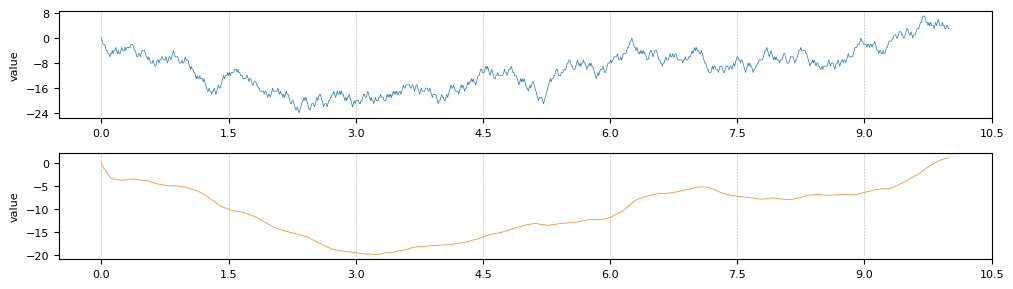

In [4]:
# Create an event set with a random walk
np.random.seed(1)
random_walk = np.cumsum(np.random.choice([-1.0, 0.0, 1.0], size=1000))

evset = tp.event_set(
	timestamps=np.linspace(0,10, num=1000),
	features={"value": random_walk}
)

# Compute a simple moving average
result = tp.simple_moving_average(evset, window_length=1)

# Plot the results
tp.plot([evset, result]) 

## Eager mode vs Graph mode

Temporian has two execution modes: **eager** and **graph**. In eager mode, operators are applied immediately. This mode is useful for learning Temporian, for iterative and interactive development, and for lightweight/small data use cases where performance isn't a priority.

In graph mode, operators are combined together into "Temporian programs" before being executed. Graph mode is more efficient and it consumes less memory. Temporian programs can be saved, inspected, and distributed by users.

Migrating a Temporian program from eager to graph mode is easy and requires little work. Most of the time, adding a `@tp.compile` annotation is enough. Therefore, it is recommended to develop programs in eager mode and then to productize them in graph mode.

Next, we see a the same program written three times: First, in eager mode, then in graph mode using `@tp.compile`, and finally in graph mode without `@tp.compile`.

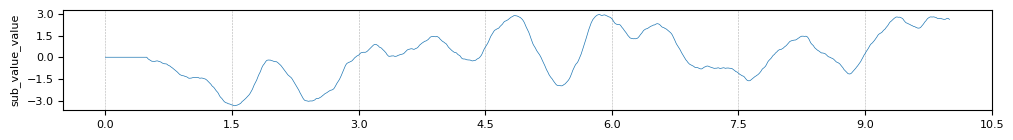

In [5]:
# Eager mode
#
# Note: This Temporian program contains three operators: two "simple_moving_average" and one "tp.substract" operators.
result = tp.simple_moving_average(evset, window_length=0.5) - tp.simple_moving_average(evset, window_length=1.0)
result.plot()

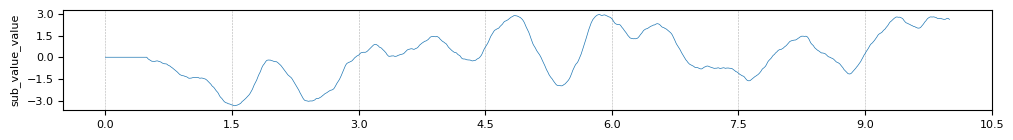

In [6]:
# Graph mode with @tp.compile

@tp.compile
def my_function(x):
    return tp.simple_moving_average(x, window_length=0.5) - tp.simple_moving_average(x, window_length=1.0)

result = my_function(evset)
    
result.plot()

Build schedule
Run 3 operators
    1 / 3: SIMPLE_MOVING_AVERAGE [0.00007 s]
    2 / 3: SIMPLE_MOVING_AVERAGE [0.00004 s]
    3 / 3: SUBTRACTION [0.00007 s]
Execution in 0.00050 s


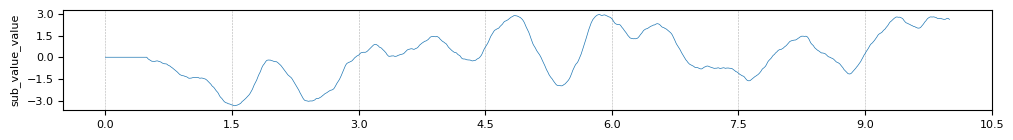

In [7]:
# Graph model without @tp.compile

input_node = tp.input_node([("value", tp.float64)])
# Or input_node = tp.input_node(evset.schema.features)

result_node = tp.simple_moving_average(input_node, window_length=0.5) - tp.simple_moving_average(input_node, window_length=1.0)
result = tp.run(result_node, {input_node: evset}, verbose=1)
    
result.plot()

## More on graph mode

**Remark:** While you will likely use the graph mode with `@tp.compile` , it is useful for you to understand the graph model without `@tp.compile`.

A Temporian program is a graph of [EventSetNode][temporian.EventSetNodes]s connecting operators. A graph is executed with the function `tp.run(<outputs>, <inputs>)`.

<img src="https://raw.githubusercontent.com/google/temporian/main/docs/src/assets/eager_and_graph.svg" width="100%" alt="eager vs graph mode">

The `<outputs>` can be specified as an `EventSetNode`, a list of `EventSetNodes`, or a dictionary of names to `EventSetNodes`, and the result of `tp.run()` will be of the same type. For example, if `<outputs>` is a list of three `EventSetNodes`, the result will be a list of the three corresponding `EventSets`.

The `<inputs>` can be specified as:

- A dictionary of `EventSetNodes` to `EventSets`, or 
- A dictionary of names to `EventSets`, or,
- A list of `EventSets`, or
- A single `EventSet`

This lets Temporian know the `EventSetNodes` of the graph that each input `EventSet` corresponds to. If `<inputs>` is a dictionary of names to `EventSets`, the names must match the names of `EventSetNodes` in the graph.  If `<inputs>` is a list or a single `EventSet`, the names of those `EventSets` must do the same. If we specify the inputs as a dictionary, we could skip passing a name to `a_evset`.

In [8]:
input_node = tp.input_node([("value", tp.float64)])
result_1_node = tp.simple_moving_average(input_node, window_length=0.5)
result_2_node = tp.simple_moving_average(input_node, window_length=1.0)
result_3_node = result_1_node - result_2_node

result = tp.run([result_1_node,result_2_node, result_3_node], {input_node: evset})
    
print(result)

[indexes: []
features: [('value', float64)]
events:
     (1000 events):
        timestamps: [ 0.    0.01  0.02 ...  9.98  9.99 10.  ]
        'value': [ 0.   -0.5  -1.   ...  3.74  3.76  3.76]
memory usage: 8.5 kB
, indexes: []
features: [('value', float64)]
events:
     (1000 events):
        timestamps: [ 0.    0.01  0.02 ...  9.98  9.99 10.  ]
        'value': [ 0.   -0.5  -1.   ...  1.04  1.09  1.14]
memory usage: 8.5 kB
, indexes: []
features: [('sub_value_value', float64)]
events:
     (1000 events):
        timestamps: [ 0.    0.01  0.02 ...  9.98  9.99 10.  ]
        'sub_value_value': [0.   0.   0.   ... 2.7  2.67 2.62]
memory usage: 8.5 kB
]


**Remarks:**

- It's important to distinguish between a `tp.EventSet`, such as `evset`, that contains data, and a `tp.EventSetNode`, like `input_node`, that connect operators together and compose the computation graph, but do not contain data.
- No computation is performed when defining the graph (i.e., when calling the operator functions). All computation is done during `tp.run()`.
- In `tp.run()`, the second argument defines a mapping between input `EventSetNodes` and `EventSets`. If all necessary input `EventSetNodes` are not fed, an error will be raised.
- In most cases you will only pass `EventSets` that correspond to the graph's input `EventSetNodes`, but Temporian also supports passing `EventSets` to intermediate `EventSetNodes` in the graph.

The `@tp.compile` annotation takes a function inputing and outputing `tp.EventSetNode`, and automatically calls `tp.run` on the result of the function if a `tp.EventSet` is provided as input.

In [9]:
@tp.compile
def my_function(x : tp.EventSetNode) -> tp.EventSetNode:
    return tp.simple_moving_average(x, window_length=0.5)

# Feeding an EventSet
input_evset = tp.event_set(timestamps=[1, 2, 3],features={"value": [5., 6., 7.]})
assert isinstance(my_function(input_evset), tp.EventSet)

# Feeding an EventSetNode
input_node = tp.input_node([("value", tp.float64)])
assert isinstance(my_function(input_node), tp.EventSetNode)

Importantly, variables in a `tp.compile` function are `EventSetNode` and not `EventSet`. Therefore, you cannot directly access the event set data.

In addition, the compiled function execution first generates the graph. The graph is then executed. In the next example, the compiled function generates a graph with 10 operators.

In [10]:
@tp.compile
def my_function(x : tp.EventSetNode) -> tp.EventSetNode:
    for i in range(10):
        x = tp.simple_moving_average(x, window_length=i+1)
    return x

You can create a compiled function with a `if`. However, the condition of the `if` cannot depend on the EventSet data.

In [11]:
@tp.compile
def my_function(x : tp.EventSetNode, a:bool) -> tp.EventSetNode:
    if a:
        return tp.rename(x, "a_branch")
    else:
        return tp.rename(x, "non_a_branch")

print(my_function(input_evset, a=True).schema.features)

print(my_function(input_evset, a=False).schema.features)

[('a_branch', float64)]
[('non_a_branch', float64)]


If you want to create a program conditional on EventSet data, you can use a `tp.filter`.

In [12]:
@tp.compile
def my_function(x : tp.EventSetNode) -> tp.EventSetNode:
    return tp.filter(x["value"], x["condition"])

my_function(tp.event_set(
	timestamps=[1,2,3],
	features={
        "value": [10, 11, 12],
        "condition":[True, True, False]}
))

indexes: []
features: [('value', int64)]
events:
     (2 events):
        timestamps: [1. 2.]
        'value': [10 11]
memory usage: 0.5 kB

To simplify its usage when the graph contains a single output `EventSetNode`, `node.run(...)` is equivalent to `tp.run(node, ...)`.


<!-- TODO
# Not implemented yet:
# d_evset = tp.run(d_node, {"a": a_evset})
# d_evset = tp.run(d_node, [a_evset])
# d_evset = tp.run(d_node, a_evset)
# d_evset = d_node.run({"a": a_evset})
# d_evset = d_node.run([a_evset])
# d_evset = d_node.run(a_evset)
-->

**Warning:** It is more efficient to run multiple output `EventSetNodes` together with `tp.run()` than to run them separately with `node_1.run(...)`, `node_2.run(...)`, etc.

Previously, we defined the input of the graph with `tp.input_node()`. This way of listing features manually and their respective data type is cumbersome.

If an `EventSet` is available (i.e., data is available) this step can be changed to use `evset.node()` instead, which will return an `EventSetNode` that is compatible with it. This is especially useful when creating `EventSets` from existing data, such as pandas DataFrames or CSV files.

In [13]:
# Define an EventSet.
a_evset = tp.event_set(
	timestamps=[0, 1, 2],
	features={
        "feature_1": [1.0, 2.0, 3.0],
        "feature_2": ["hello", "little", "dog"],
        "feature_3": ["A", "A", "B"],
	}
)

# The following three statements are (almost) equivalent.
a_node = tp.input_node(
    features=[
        ("feature_1", tp.float64),
        ("feature_2", tp.str_),
    ],
    indexes=[("feature_3", tp.str_)])

a_node = tp.input_node(features=a_evset.schema.features,
                       indexes=a_evset.schema.indexes)
    
a_node = a_evset.node()


## Time units

In Temporian, times are always represented by a float64 value. Users have the freedom to choose the semantic to this value. For example, the time can be the number of nanoseconds since the start of the day, the number of cycles of a process, the number of years since the big bang, or the number of seconds since January 1, 1970, at 00:00:00 UTC, also known as Unix or POSIX time.

To ease the feature engineering of dates, Temporian contains a set of _calendar operators_. These operators specialize in creating features from dates and datetimes. For instance, the `tp.calendar_hour()` operator returns the hour of the date in the range `0-23`.

Calendar operators require the time in their inputs to be Unix time, so applying them on non-Unix timestamps will raise errors. Temporian can sometimes automatically recognize if input timestamps correspond to Unix time (e.g. when an `EventSet` is created from a pandas DataFrame with a datetime column, or when passing a list of datetime objects as timestamps in `EventSet`'s constructor). If creating `EventSets` manually and passing floats directly to `timestamps`, you need to explicitly specify whether they correspond to Unix times or not via the `is_unix_timestamp` argument.

In [14]:
a_evset = tp.event_set(
    timestamps=[
        pd.to_datetime("Monday Mar 13 12:00:00 2023", utc=True),
        pd.to_datetime("Tuesday Mar 14 12:00:00 2023", utc=True),
        pd.to_datetime("Friday Mar 17 00:00:01 2023", utc=True),
    ],
    features={
        "feature_1": [1, 2, 3],
        "feature_2": ["a", "b", "c"],
    },
)
a_node = a_evset.node()
b_node = tp.glue(a_node, tp.calendar_day_of_week(a_node))
b_node.run(a_evset)

indexes: []
features: [('feature_1', int64), ('feature_2', str_), ('calendar_day_of_week', int32)]
events:
     (3 events):
        timestamps: [1.6787e+09 1.6788e+09 1.6790e+09]
        'feature_1': [1 2 3]
        'feature_2': [b'a' b'b' b'c']
        'calendar_day_of_week': [0 1 4]
memory usage: 0.8 kB


Temporian accepts time inputs in various formats, including integer, float, Python date or datetime, NumPy datetime, and pandas datetime. Date and datetime objects are internally converted to floats as Unix time in seconds, compatible with the calendar operators.

Operators can take _durations_ as input arguments. For example, the simple moving average operator takes a `window_length` argument. Temporian exposes several utility functions to help creating those duration arguments when using Unix timestamps:

In [15]:
a = tp.input_node(features=[("feature_1", tp.float64)])

# Define a 1-day moving average.
b = tp.simple_moving_average(a, window_length=tp.duration.days(1))

# Equivalent.
b = tp.simple_moving_average(a, window_length=24 * 60 * 60)


## Plotting

Data visualization is crucial for gaining insights into data and the system it represents. It also helps in detecting unexpected behavior and issues, making debugging and iterative development easier.

Temporian provides two plotting functions for data visualization: `evset.plot()` and `tp.plot()`.

The `evset.plot()` function is shorter to write and is used for displaying a single `EventSet`, while the `tp.plot()` function is used for displaying multiple `EventSets` together. This function is particularly useful when `EventSets` are indexed (see [Index, horizontal and vertical operators](#indexes-horizontal-and-vertical-operators)) or have different samplings (see [Sampling](#sampling)).

Here's an example of using the `evset.plot()` function:

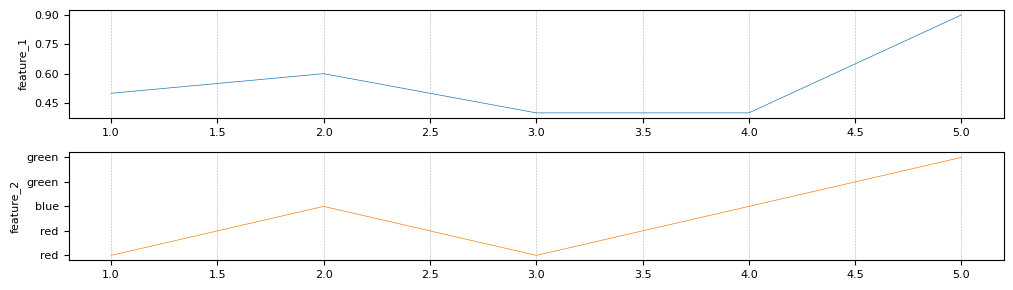

In [16]:
evset = tp.event_set(
	timestamps=[1, 2, 3, 4, 5],
	features={
        "feature_1": [0.5, 0.6, 0.4, 0.4, 0.9],
        "feature_2": ["red", "blue", "red", "blue", "green"]
    }
)
evset.plot()


By default, the plotting style is selected automatically based on the data.

For example, uniformly sampled numerical features (i.e., time series) are plotted with a continuous line, while non-uniformly sampled values are plotted with markers. Those and other behaviors can be controlled via the function's arguments.

Here's an example of using the `evset.plot()` function with options:

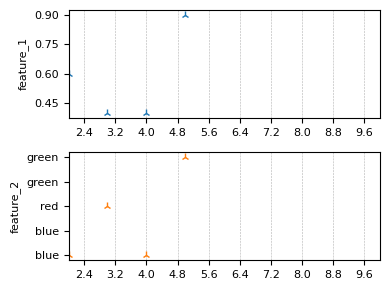

In [17]:
figure = evset.plot(
    style="marker",
    width_px=400,
    min_time=2,
    max_time=10,
    return_fig=True,
)


The plots are static images by default. However, interactive plotting can be very powerful. To enable interactive plotting, use `interactive=True`. Note that interactive plotting requires the `bokeh` Python library to be installed.

In [18]:
!pip install bokeh -q

evset.plot(interactive=True)


## Feature naming

Each feature is identified by a name, and the list of features is available through the `features` property of an `EventSetNode`.

In [19]:
events = tp.event_set(
	timestamps=[1,2,3,4,5],
	features={
	    "feature_1": [0.5, 0.6, 0.4, 0.4, 0.9],
	    "feature_2": [1.0, 2.0, 3.0, 2.0, 1.0]}
    )
node = events.node()
print(node.features)

[('feature_1', float64), ('feature_2', float64)]



Most operators do not change the input feature's names.

In [20]:
tp.moving_sum(node, window_length=10).features

[('feature_1', float64), ('feature_2', float64)]


Some operators combine two input features with different names, in which case the output name is also combined.

In [21]:
result = node["feature_1"] * node["feature_2"]
result.features

[('mult_feature_1_feature_2', float64)]


The calendar operators don't depend on input features but on the timestamps, so the output feature name doesn't
relate to the input feature names.

In [22]:
date_events = tp.event_set(
	timestamps=["2020-02-15", "2020-06-20"],
	features={"some_feature": [10, 20]}
    )
date_node = date_events.node()
print(tp.calendar_month(date_node).features)

[('calendar_month', int32)]



You can modify feature names using the `tp.rename()` and `tp.prefix()` operators. `tp.rename()` changes the name of features, while `tp.prefix()` adds a prefix in front of existing feature names. Note that they do not modify the content of the input `EventSetNode`, but return a new `EventSetNode` with the modified feature names.

In [23]:
# Rename a single feature.
renamed_f1 = tp.rename(node["feature_1"], "renamed_1")
print(renamed_f1.features)

[('renamed_1', float64)]


In [24]:
# Rename all features.
renamed_node = tp.rename(node,
    {"feature_1": "renamed_1", "feature_2": "renamed_2"}
)
print(renamed_node.features)

[('renamed_1', float64), ('renamed_2', float64)]


In [25]:
# Prefix a single feature.
prefixed_f1 = tp.prefix(node["feature_1"], "prefixed.")
print(prefixed_f1.features)

[('prefixed.feature_1', float64)]


In [26]:
# Prefix all features.
prefixed_node = tp.prefix(node, "prefixed.")
print(prefixed_node.features)

[('prefixed.feature_1', float64), ('prefixed.feature_2', float64)]



It is recommended to use `tp.rename()` and `tp.prefix()` to organize your data, and avoid duplicated feature names.

In [27]:
sma_7_node = tp.prefix(tp.simple_moving_average(node, tp.duration.days(7)), "sma_7.")
sma_14_node = tp.prefix(tp.simple_moving_average(node, tp.duration.days(14)), "sma_14.")


The `tp.glue()` operator can be used to concatenate different features into a single `EventSetNode`, but it will fail if two features with the same name are provided. The following pattern is commonly used in Temporian programs.

In [28]:
result = tp.glue(
    tp.prefix(tp.simple_moving_average(node, tp.duration.days(7)), "sma_7."),
    tp.prefix(tp.simple_moving_average(node, tp.duration.days(14)), "sma_14."),
)


## Casting

Temporian is strict on feature data types (also called dtype). This means that often, you cannot perform operations between features of different types. For example, you cannot subtract a `tp.float32` and a `tp.float64`. Instead, you must manually cast the features to the same type before performing the operation.

In [29]:
node = tp.input_node(features=[("f1", tp.float32), ("f2", tp.float64)])
added = tp.cast(node["f1"], tp.float64) + node["f2"]


Casting is especially useful to reduce memory usage. For example, if a feature only contains values between 0 and 10000, using `tp.int32` instead of `tp.int64` will halve memory usage. These optimizations are critical when working with large datasets.

Casting can also be a necessary step before calling operators that only accept certain input data types.

Note that in Python, the values `1.0` and `1` are respectively `float64` and `int64`.

Temporian supports data type casting through the `tp.cast()` operator. Destination data types can be specified in three different ways:

1. Single data type: converts all input features to the same destination data type.

   

In [30]:
node.features

[('f1', float32), ('f2', float64)]

In [31]:
print(tp.cast(node, tp.str_).features)

[('f1', str_), ('f2', str_)]



2. Feature name to data type mapping: converts each feature (specified by name) to a specific data type.

In [32]:
print(tp.cast(node, {"f1": tp.str_, "f2": tp.int64}).features)

[('f1', str_), ('f2', int64)]



3. Data type to data type mapping: converts all features of a specific data type to another data type.

In [33]:
print(tp.cast(node, {tp.float32: tp.str_, tp.float64: tp.int64}).features)

[('f1', str_), ('f2', int64)]



Keep in mind that casting may fail when the graph is evaluated. For instance, attempting to cast `"word"` to `tp.float64` will result in an error. These errors cannot be caught prior to graph evaluation.

## Arithmetic operators

Arithmetic operators can be used between the features of an `EventSetNode`, to perform element-wise calculations.

Common mathematical and bit operations are supported, such as addition (`+`), subtraction (`-`), product (`*`), division (`/`), floor division (`//`), modulo (`%`), comparisons (`>, >=, <, <=`), and bitwise operators (`&, |, ~`).

These operators are applied index-wise and timestamp-wise, between features in the same position.

In [34]:
evset = tp.event_set(
    timestamps=[1, 10],
    features={
        "f1": [0, 1],
        "f2": [10.0, 20.0],
        "f3": [100, 100],
        "f4": [1000.0, 1000.0],
    },
)
node = evset.node()

node_added = node[["f1", "f2"]] + node[["f3", "f4"]]

evset_added = node_added.run(evset)
print(evset_added)

indexes: []
features: [('add_f1_f3', int64), ('add_f2_f4', float64)]
events:
     (2 events):
        timestamps: [ 1. 10.]
        'add_f1_f3': [100 101]
        'add_f2_f4': [1010. 1020.]
memory usage: 0.7 kB




Note that features of type `int64` and `float64` are not mixed above, because otherwise the operation would fail without an explicit type cast.

```python
# Attempt to mix dtypes.
>>> node["f1"] + node["f2"]
Traceback (most recent call last):
    ...
ValueError: corresponding features should have the same dtype. ...
```


Refer to the [Casting](#casting) section for more on this.

All the operators have an equivalent functional form. The example above using `+`, could be rewritten with `tp.add()`.

In [35]:
# Equivalent.
node_added = tp.add(node[["f1", "f2"]], node[["f3", "f4"]])


Other usual comparison and logic operators also work (except `==`, see below).

In [36]:
is_greater = node[["f1", "f2"]] > node[["f3", "f4"]]
is_less_or_equal = node[["f1", "f2"]] <= node[["f3", "f4"]]
is_wrong = is_greater & is_less_or_equal


**Warning:** The Python equality operator (`==`) does not compute element-wise equality between features. Use the `tp.equal()` operator instead.

In [37]:
# Works element-wise as expected
tp.equal(node["f1"], node["f3"])

schema:
    features: [('eq_f1_f3', bool_)]
    indexes: []
    is_unix_timestamp: False

features: [Feature(id=140558094330624, creator=Operator(key='EQUAL', id=66, attributes={}))]
sampling: Sampling(id=140557545245616, creator=None),
name: None
creator: Operator(key='EQUAL', id=66, attributes={})
id:140558094330240

In [38]:
# This is just a boolean
(node["f1"] == node["f3"])
False

False


All these operators act feature-wise, i.e. they perform index-feature-wise operations (for each feature in each index key). This implies that the input `EventSetNodes` must have the same number of features.

```python
node[["f1", "f2"]] + node["f3"]
Traceback (most recent call last):
    ...
ValueError: The left and right arguments should have the same number of features. ...
```


The input `EventSetNodes` must also have the same sampling and index.

```python
sampling_1 = tp.event_set(
    timestamps=[0, 1],
    features={"f1": [1, 2]},
)
sampling_2 = tp.event_set(
    timestamps=[1, 2],
    features={"f1": [3, 4]},
)
sampling_1.node() + sampling_2.node()
Traceback (most recent call last):
    ...
ValueError: Arguments should have the same sampling. ...
```


If you want to apply arithmetic operators on `EventSetNodes` with different samplings, take a look at
[Sampling](#sampling) section.

If you want to apply them on `EventSetNodes` with different indexes, check the
[Vertical operators](#indexes-horizontal-and-vertical-operators) section.

Operations involving scalars are applied index-feature-element-wise.

In [39]:
node_scalar = node * 10
print(node_scalar.run(evset))

indexes: []
features: [('f1', int64), ('f2', float64), ('f3', int64), ('f4', float64)]
events:
     (2 events):
        timestamps: [ 1. 10.]
        'f1': [ 0 10]
        'f2': [100. 200.]
        'f3': [1000 1000]
        'f4': [10000. 10000.]
memory usage: 0.9 kB




## Sampling

Arithmetic operators, such as `tp.add()`, require their input arguments to have the same timestamps and [Index](#indexes-horizontal-and-vertical-operators). The unique combination of timestamps and indexes is called a _sampling_.

<!-- TODO: example -->

For example, if `EventSetNodes` `a` and `b` have different samplings, `a["feature_1"] + b["feature_2"]` will fail.

To use arithmetic operators on `EventSets` with different samplings, one of the `EventSets` needs to be resampled to the sampling of the other `EventSet`. Resampling is done with the `tp.resample()` operator.

The `tp.resample()` operator takes two `EventSets` called `input` and `sampling`, and returns the resampling of the features of `input` according to the timestamps of `sampling` according to the following rules:

If a timestamp is present in `input` but not in `sampling`, the timestamp is dropped.
If a timestamp is present in both `input` and `sampling`, the timestamp is kept.
If a timestamp is present in `sampling` but not in `input`, a new timestamp is created using the feature values from the _closest anterior_ (not the closest, as that could induce future leakage) timestamp of `input`. This rule is especially useful for events that represent measurements (see [Events and `EventSets`](#events-and-eventsets)).

**Note:** Features in `sampling` are ignored. This also happens in some other operators that take a `sampling` argument of type `EventSetNode` - it indicates that only the sampling (a.k.a. the indexes and timestamps) of that `EventSetNode` are being used by that operator.

Given this example:

In [40]:
evset = tp.event_set(
    timestamps=[10, 20, 30],
    features={
        "x": [1.0, 2.0, 3.0],
    },
)
node = evset.node()
sampling_evset = tp.event_set(
    timestamps=[0, 9, 10, 11, 19, 20, 21],
)
sampling_node = sampling_evset.node()
resampled = tp.resample(input=node, sampling=sampling_node)
resampled.run({node: evset, sampling_node: sampling_evset})

indexes: []
features: [('x', float64)]
events:
     (7 events):
        timestamps: [ 0.  9. 10. 11. 19. 20. 21.]
        'x': [nan nan  1.  1.  1.  2.  2.]
memory usage: 0.6 kB


The following would be the matching between the timestamps of `sampling` and `input`:

| `sampling` timestamp         | 0   | 9   | 10  | 11  | 19  | 20  | 21  |
| ---------------------------- | --- | --- | --- | --- | --- | --- | --- |
| matching `input` timestamp   | -   | -   | 10  | 10  | 10  | 20  | 20  |
| matching `"x"` feature value | NaN | NaN | 1   | 1   | 1   | 2   | 2   |

If `sampling` contains a timestamp anterior to any timestamp in the `input` (like 0 and 9 in the example above), the feature of the sampled event will be missing. The representation of a missing value depends on its dtype:

float: `NaN`
integer: `0`
string: `""`

Back to the example of the `tp.add()` operator, `a` and `b` with different sampling can be added as follows:

In [41]:
sampling_a = tp.event_set(
    timestamps=[0, 1, 2],
    features={"f1": [10, 20, 30]},
)
sampling_b = tp.event_set(
    timestamps=[1, 2, 3],
    features={"f1": [5, 4, 3]},
)
a = sampling_a.node()
b = sampling_b.node()
result = a + tp.resample(b, a)
result.run({a: sampling_a, b: sampling_b})

indexes: []
features: [('add_f1_f1', int64)]
events:
     (3 events):
        timestamps: [0. 1. 2.]
        'add_f1_f1': [10 25 34]
memory usage: 0.6 kB


`tp.resample()` is critical to combine events from different, non-synchronized sources. For example, consider a system with two sensors, a thermometer for temperature and a manometer for pressure. The temperature sensor produces measurements every 1 to 10 minutes, while the pressure sensor returns measurements every second. Additionally assume that both sensors are not synchronized. Finally, assume that you need to combine the temperature and pressure measurements with the equation `temperature / pressure`.

<!-- TODO: image -->

Since the temperature and pressure `EventSets` have different sampling, you will need to resample one of them. The pressure sensor has higher resolution. Therefore, resampling the temperature to the pressure yields higher resolution than resampling the pressure to the temperature.

```python
r = tp.resample(termometer["temperature"], manometer) / manometer["pressure"]
```


When handling non-uniform timestamps it is also common to have a common resampling source.

```python
sampling_source = # Uniform timestamps every 10 seconds.
r = tp.resample(termometer["temperature"], sampling_source) / tp.resample(manometer["pressure"], sampling_source)
```

Moving window operators, such as the `tp.simple_moving_average()` or `tp.moving_count()` operators, have an optional `sampling` argument. For example, the signature of the simple moving average operator is `tp.simple_moving_average()(][temporian.simple_moving_average]input: EventSetNode, window_length: Duration, sampling: Optional[EventSetNode] = None)`. If `sampling`is not set, the result will maintain the sampling of the`input`argument. If`sampling`is set, the moving window will be sampled at each timestamp of`sampling` instead, and the result will have those new ones.

```python
b = tp.simple_moving_average(input=a, window_length=10)
c = tp.simple_moving_average(input=a, window_length=10, sampling=d)
```

Note that if planning to resample the result of a moving window operator, passing the `sampling` argument is both more efficient and more accurate than calling `tp.resample()` on the result.

## Indexes, horizontal and vertical operators

All operators presented so far work on a sequence of related events. For instance, the simple moving average operator computes the average of events within a specific time window. These types of operators are called _horizontal operators_.

It is sometimes desirable for events in an `EventSet` not to interact with each other. For example, assume a dataset containing the sum of daily sales of a set of products. The objective is to compute the sum of weekly sales of each product independently. In this scenario, the weekly moving sum should be applied individually to each product. If not, you would compute the weekly sales of all the products together.

To compute the weekly sales of individual products, you can define the `product` feature as the _index_.

In [42]:
daily_sales = tp.event_set(
	timestamps=["2020-01-01", "2020-01-01", "2020-01-02", "2020-01-02"],
	features={
        "product": [1, 2, 1, 2],
        "sale": [100.0, 300.0, 90.0, 400.0],
    },
    indexes=["product"]
)
print(daily_sales)

indexes: [('product', int64)]
features: [('sale', float64)]
events:
    product=1 (2 events):
        timestamps: [1.5778e+09 1.5779e+09]
        'sale': [100.  90.]
    product=2 (2 events):
        timestamps: [1.5778e+09 1.5779e+09]
        'sale': [300. 400.]
memory usage: 0.9 kB




The moving sum operator will then be applied independently to the events corresponding to each product.

In [43]:
a = daily_sales.node()

# Compute the moving sum of each index group (a.k.a. each product) individually.
b = tp.moving_sum(a, window_length=tp.duration.weeks(1))

b.run({a: daily_sales})

indexes: [('product', int64)]
features: [('sale', float64)]
events:
    product=1 (2 events):
        timestamps: [1.5778e+09 1.5779e+09]
        'sale': [100. 190.]
    product=2 (2 events):
        timestamps: [1.5778e+09 1.5779e+09]
        'sale': [300. 700.]
memory usage: 0.9 kB


Horizontal operators can be understood as operators that are applied independently on each index.

Operators that modify an `EventSetNode`'s indexes are called _vertical operators_. The most important vertical operators are:

- `tp.add_index()`: Add features to the index.
- `tp.drop_index()`: Remove features from the index, optionally keeping them as features.
- `tp.set_index()`: Changes the index.
- `tp.propagate()`: Expand indexes based on another `EventSet`’s indexes.

By default, `EventSets` are _flat_, which means they have no index, and therefore all events are in a single global group.

Also, keep in mind that only string and integer features can be used as indexes.

`EventSets` can have multiple features as index. In the next example, assume our daily sale aggregates are also annotated with `store` data.

In [44]:
daily_sales = tp.event_set(
	timestamps=["2020-01-01", "2020-01-01", "2020-01-02", "2020-01-02"],
	features={
        "store": [1, 1, 1, 2],
        "product": [1, 2, 1, 2],
        "sale": [100.0, 200.0, 110.0, 300.0],
    },
)
print(daily_sales)

indexes: []
features: [('store', int64), ('product', int64), ('sale', float64)]
events:
     (4 events):
        timestamps: [1.5778e+09 1.5778e+09 1.5779e+09 1.5779e+09]
        'store': [1 1 1 2]
        'product': [1 2 1 2]
        'sale': [100. 200. 110. 300.]
memory usage: 0.9 kB




Since we haven't defined the `indexes` yet, `store` and `product` are just regular features above.
Let's add the `(product, store)` pair as the index.

In [45]:
a = daily_sales.node()
b = tp.add_index(a, ["product", "store"])
b.run({a: daily_sales})

indexes: [('product', int64), ('store', int64)]
features: [('sale', float64)]
events:
    product=1 store=1 (2 events):
        timestamps: [1.5778e+09 1.5779e+09]
        'sale': [100. 110.]
    product=2 store=1 (1 events):
        timestamps: [1.5778e+09]
        'sale': [200.]
    product=2 store=2 (1 events):
        timestamps: [1.5779e+09]
        'sale': [300.]
memory usage: 1.2 kB


The `moving_sum` operator can be used to calculate the weekly sum of sales
for each `(product, store)` pair.

In [46]:
# Weekly sales by product and store
c = tp.moving_sum(b["sale"], window_length=tp.duration.weeks(1))
c.run({a: daily_sales})

indexes: [('product', int64), ('store', int64)]
features: [('sale', float64)]
events:
    product=1 store=1 (2 events):
        timestamps: [1.5778e+09 1.5779e+09]
        'sale': [100. 210.]
    product=2 store=1 (1 events):
        timestamps: [1.5778e+09]
        'sale': [200.]
    product=2 store=2 (1 events):
        timestamps: [1.5779e+09]
        'sale': [300.]
memory usage: 1.2 kB


If we want the weekly sum of sales per `store`, we can just drop the `product` index.

In [47]:
# Weekly sales by store (including all products)
d = tp.drop_index(b, "product")
e = tp.moving_sum(d["sale"], window_length=tp.duration.weeks(1))
e.run({a: daily_sales})

indexes: [('store', int64)]
features: [('sale', float64)]
events:
    store=1 (3 events):
        timestamps: [1.5778e+09 1.5778e+09 1.5779e+09]
        'sale': [300. 300. 410.]
    store=2 (1 events):
        timestamps: [1.5779e+09]
        'sale': [300.]
memory usage: 0.9 kB


Finally, let's calculate the ratio of sales of each `(product, store)` pair compared to the whole `store` sales.

Since `c` (weekly sales for each product and store) and `e` (weekly sales for each store) have different indexes, we cannot use `tp.divide` (or `/`) directly - we must first `propagate` `e` to the `["product", "store"]` index.

In [48]:
# Copy the content of e (indexed by (store)) into each (store, product).
f = c / tp.propagate(e, sampling=c, resample=True)

# Equivalent.
f = c / tp.resample(
    tp.propagate(e, sampling=c),
    sampling=c,
)
print(f.run({a: daily_sales}))

indexes: [('product', int64), ('store', int64)]
features: [('div_sale_sale', float64)]
events:
    product=1 store=1 (2 events):
        timestamps: [1.5778e+09 1.5779e+09]
        'div_sale_sale': [0.3333 0.5122]
    product=2 store=1 (1 events):
        timestamps: [1.5778e+09]
        'div_sale_sale': [0.6667]
    product=2 store=2 (1 events):
        timestamps: [1.5779e+09]
        'div_sale_sale': [1.]
memory usage: 1.2 kB




The `tp.propagate()` operator expands the indexes of its `input` (`e` in this case) to match the indexes of its `sampling` by copying the content of `input` into each corresponding index group of `sampling`. Note that `sampling`'s indexes must be a superset of `input`'s indexes.

## Future leakage

In supervised learning, [leakage](<https://en.wikipedia.org/wiki/Leakage_(machine_learning)>) is the use of data not available at serving time by a machine learning model. A common example of leakage is _label leakage_, which involves the invalid use of labels in the model input features. Leakage tends to bias model evaluation by making it appear much better than it is in reality. Unfortunately, leakage is often subtle, easy to inject, and challenging to detect.

Another type of leakage is future leakage, where a model uses data before it is available. Future leakage is particularly easy to create, as all feature data is ultimately available to the model, the problem being it being accessed at the wrong time.

To avoid future leakage, Temporian operators are guaranteed to not cause future leakage, except for the `tp.leak()` operator. This means that it is impossible to inadvertently add future leakage to a Temporian program.

`tp.leak()` can be useful for precomputing labels or evaluating machine learning models. However, its outputs shouldn’t be used as input features.

In [49]:
a = tp.input_node(features=[("feature_1", tp.float32)])
b = tp.moving_count(a, 1)
c = tp.moving_count(tp.leak(b, 1), 2)


In this example, `b` does not have a future leak, but `c` does because it depends on `tp.leak()`.

<!-- TODO: Not implemented yet

To check programmatically if a `Node` depends on `tp.leak()`, we can use the `tp.has_leak()` function.

# print(tp.has_leak(b))
# False

# print(tp.has_leak(c))
# True


By using `tp.has_leak()`, we can programmatically identify future leakage and modify our code accordingly.
-->

## Accessing `EventSet` data

`EventSet` data can be accessed using their `data` attribute. Temporian internally relies on NumPy, which means that the data access functions always return NumPy arrays.

In [50]:
evset = tp.event_set(
	timestamps=[1, 2, 3, 5, 6],
	features={
        "f1": [0.1, 0.2, 0.3, 1.1, 1.2],
        "f2": ["red", "red", "red", "blue", "blue"],
	},
	indexes=["f2"],
)

# Access the data for the index group `f2=red`.
evset.get_index_value(("red",))

IndexData(features=[array([0.1, 0.2, 0.3])], timestamps=array([1., 2., 3.]))


<!--
`EventSet` data can be accessed using the `index()` and `feature()` functions. Temporian internally relies on NumPy, which means that the data access functions always return NumPy arrays.

evset = tp.event_set(
	timestamps=[1, 2, 3, 5, 6],
	features={
        "f1": [0.1, 0.2, 0.3, 1.1, 1.2],
        "f2": ["red", "red", "red", "blue", "blue"],
	},
	indexes=["f2"],
)

# Access the data for the index group `f2=red`.
evset.index("red")


# Equivalent.
evset.index(("red", ))


# Access the data for the index group `f2=red` and feature `f1`.
evset.index("red").feature("f1")


If an `EventSet` does not have an index, `feature` can be called directly:

evset = tp.event_set(
	timestamps=[1, 2, 3, 5, 6],
	features={
        "f1": [0.1, 0.2, 0.3, 1.1, 1.2],
        "f2": ["red", "red", "red", "blue", "blue"],
	},
)
evset.feature("f1")
-->

## Import and export data

`EventSets` can be read from and saved to csv files via the `tp.from_csv()` and `tp.to_csv()` functions.

# Read EventSet from a .csv file.

```python
evset = tp.from_csv(
    path="path/to/file.csv",
    timestamps="timestamp",
    indexes=["product_id"],
)

# Save EventSet to a .csv file.
tp.to_csv(evset, path="path/to/file.csv")
```

Converting `EventSet` data to and from pandas DataFrames is also easily done via `tp.to_pandas()` and `tp.from_pandas()`.

In [51]:
df = pd.DataFrame({
    "timestamp": [1, 2, 3, 5, 6],
    "f1": [0.1, 0.2, 0.3, 1.1, 1.2],
    "f2": ["red", "red", "red", "blue", "blue"],
})

# Create EventSet from DataFrame.
evset = tp.from_pandas(df)

# Convert EventSet to DataFrame.
df = tp.to_pandas(evset)


## Serialization and deserialization of a graph

Temporian graphs can be exported and imported to a safe-to-share file with `tp.save_graph()` and `tp.load_graph()`. In both functions input and output `EventSetNodes` need to be named, or be assigned a name by passing them as a dictionary.

```python
# Define a graph.
evset = tp.event_set(
	timestamps=[1, 2, 3],
	features={"f1": [0.1, 0.2, 0.3]},
)
a = evset.node()
b = tp.moving_count(a, 1)

# Save the graph.
tp.save_graph(inputs={"input_a": a}, outputs={"output_b": b}, path="/tmp/my_graph.tem")

# Equivalent.
a.name = "input_a"
b.name = "output_b"
tp.save_graph(inputs=a, outputs=[b], path="/tmp/my_graph.tem")

# Load the graph.
loaded_inputs, loaded_outputs = tp.load_graph(path="/tmp/my_graph.tem")

# Run data on the restored graph.
tp.run(loaded_outputs["output_b"], {loaded_inputs["input_a"]: evset})
```